<a href="https://colab.research.google.com/github/partha1189/Udacity-DLND/blob/master/MNIST_PYTORCH_WITH_VALIDATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x577e4000 @  0x7fe5a9f822a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [2]:
!pip install Pillow

In [0]:
# import libraries
import torch
import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

In [4]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data',train= True,download=True,transform=transform)
test_data = datasets.MNIST(root='data',train=False,download=True,transform=transform)

num_train = len(train_data)
indices = list(range(num_train))

Processing...
Done!


In [5]:
num_train

60000

In [0]:
np.random.shuffle(indices)

In [0]:
split = int(np.floor(valid_size * num_train))

In [9]:
split

12000

In [0]:
train_idx,valid_idx = indices[split:],indices[:split]

In [0]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=valid_sampler,num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,num_workers=num_workers)

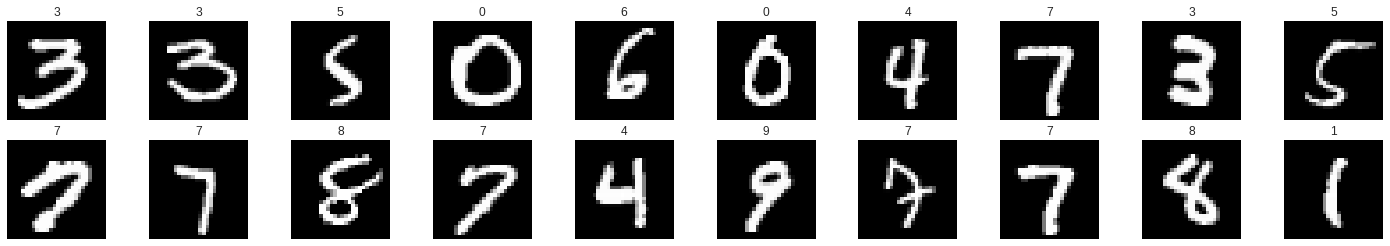

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    
    hidden_1 = 512
    hidden_2 = 512
    
    self.fc1 = nn.Linear(28 * 28,hidden_1)
    self.fc2 = nn.Linear(hidden_1,hidden_2)
    self.fc3 = nn.Linear(hidden_2,10)
    
    self.dropout = nn.Dropout(0.2)
    
  def forward(self,x):
    
    x = x.view(-1,28 * 28)
    
    x = F.relu(self.fc1(x))
    
    x = self.dropout(x)
    
    x = F.relu(self.fc2(x))
    
    x = self.dropout(x)
    
    x = self.fc3(x)
    
    return x
    
    
    
model = Net()
print(model)
    
    

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


In [0]:
criterion = nn.CrossEntropyLoss()
from torch import optim
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [19]:
n_epochs = 20

#initialize tracker for min_valid_loss
valid_loss_min = np.Inf

for e in range(n_epochs):
  
  train_loss = 0.0
  valid_loss = 0.0
  
  ##############
  # TRAIN MODEL#
  ##############
  
  model.train()
  for data,target in train_loader:
    optimizer.zero_grad()
    
    output = model(data)
    
    loss = criterion(output,target)
    
    loss.backward()
    
    optimizer.step()
    
    train_loss += loss.item()*data.size(0)
  
  ##################
  # VALIDATE MODEL #
  ##################
  model.eval()
  for data,target in valid_loader:
    
    output = model(data)
    
    loss = criterion(output,target)
    
    valid_loss += loss.item()*data.size(0)
    
  train_loss = train_loss/len(train_loader.dataset)
  valid_loss = valid_loss/len(valid_loader.dataset)
  
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e+1, 
        train_loss,
        valid_loss
        ))
  
  #SAVE MODEL IF VALID_LOSS HAS DECREASED
  
  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
    valid_loss_min,
    valid_loss))
    
    torch.save(model.state_dict(),'model.pt')
    valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 0.458091 	Validation Loss: 0.076387
Validation loss decreased (inf --> 0.076387).  Saving model ...
Epoch: 2 	Training Loss: 0.434056 	Validation Loss: 0.074681
Validation loss decreased (0.076387 --> 0.074681).  Saving model ...
Epoch: 3 	Training Loss: 0.399411 	Validation Loss: 0.067464
Validation loss decreased (0.074681 --> 0.067464).  Saving model ...
Epoch: 4 	Training Loss: 0.375212 	Validation Loss: 0.062720
Validation loss decreased (0.067464 --> 0.062720).  Saving model ...
Epoch: 5 	Training Loss: 0.371919 	Validation Loss: 0.071235
Epoch: 6 	Training Loss: 0.379447 	Validation Loss: 0.068518
Epoch: 7 	Training Loss: 0.374430 	Validation Loss: 0.072261
Epoch: 8 	Training Loss: 0.353137 	Validation Loss: 0.073328
Epoch: 9 	Training Loss: 0.371763 	Validation Loss: 0.061512
Validation loss decreased (0.062720 --> 0.061512).  Saving model ...
Epoch: 10 	Training Loss: 0.319890 	Validation Loss: 0.062009
Epoch: 11 	Training Loss: 0.345786 	Validation Lo

In [0]:
model.load_state_dict(torch.load('model.pt'))

In [21]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.337004

Test Accuracy of     0: 95% (940/980)
Test Accuracy of     1: 97% (1103/1135)
Test Accuracy of     2: 95% (988/1032)
Test Accuracy of     3: 89% (902/1010)
Test Accuracy of     4: 95% (938/982)
Test Accuracy of     5: 90% (810/892)
Test Accuracy of     6: 93% (891/958)
Test Accuracy of     7: 97% (1000/1028)
Test Accuracy of     8: 88% (865/974)
Test Accuracy of     9: 88% (888/1009)

Test Accuracy (Overall): 93% (9325/10000)


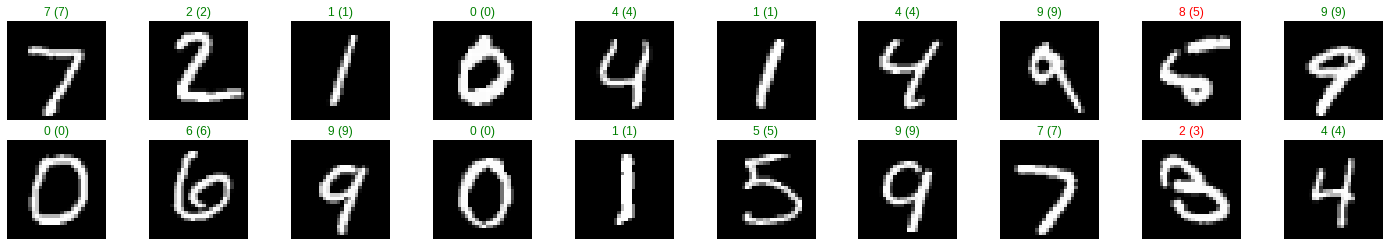

In [22]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))